# Rethinking Statistics course in NumPyro - Week 9

Lecture 17: Adventures in Covariance

- [Video](https://www.youtube.com/watch?v=yfXpjmWgyXU)
- [Slides](https://speakerdeck.com/rmcelreath/l17-statistical-rethinking-winter-2019)

Lecture 18: Slopes, Instruments and Social Relations

- [Video](https://www.youtube.com/watch?v=e5cgiAGBKzI)
- [Slides](https://speakerdeck.com/rmcelreath/l18-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week09.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week09_solutions.pdf) for the exercises of the week.

In [1]:
import pandas as pd
import numpy as np

import jax.numpy as jnp
from jax import random
from jax.scipy.special import expit as logistic
import numpyro
from numpyro.infer import NUTS, MCMC, Predictive
import numpyro.distributions as dist

import seaborn as sns
import arviz as az

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Mar 27 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.21.0

pandas : 1.2.3
seaborn: 0.11.1
numpyro: 0.6.0
arviz  : 0.11.2
numpy  : 1.20.1
jax    : 0.2.10

Watermark: 2.2.0



In [3]:
rng_key = random.PRNGKey(0)
sns.set_style('whitegrid')

## Exercise 1

> Revisit the Bangladesh fertility data, data(`bangladesh`). Fit a model with both varying intercepts by `district_id` and varying slopes of `urban` (as a 0/1 indicator variable) by `district_id`. You are still predicting `use.contraception`. Inspect the correlation between the intercepts and slopes. Can you interpret this correlation, in terms of what it tells you about the pattern of contraceptive use in the sample? It might help to plot the varying effect estimates for both the intercepts and slopes by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Plotting predicted proportion of women using contraception, in each district, with urban women on one axis and rural on the other, might also help.

In [4]:
d = pd.read_csv('./dat/bangladesh.csv', header=0, sep=';')
d['did'] = pd.factorize(d['district'])[0]
normalize = lambda x: (x - x.mean())/x.std()
d['children'] = normalize(d['living.children'])
d['age'] = normalize(d['age.centered'])
d.rename(columns={'use.contraception':'contra'}, inplace=True)
d.tail(3)

,woman,district,contra,living.children,age.centered,urban,did,children,age
1931,1932,61,0,4,14.44,0,59,1.084782,1.601843
1932,1933,61,0,1,-13.56,0,59,-1.329451,-1.504697
1933,1934,61,0,4,10.44,0,59,1.084782,1.158052


This is a conventional varying slopes model, with a centered parameterization. No surprises. If you peek at the posterior distributions for the average effects, you'll see that the average slope is positive:

In [5]:
# https://fehiepsi.github.io/rethinking-numpyro/14-adventures-in-covariance.html

def model(did, urban, contra=None):
    # fixed priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0, 1))
    b_bar = numpyro.sample('b_bar', dist.Normal(0, 0.5))
    sigma_ab = numpyro.sample('sigma_ab', dist.Exponential(1), sample_shape=(2,))
    rho = numpyro.sample('rho', dist.LKJ(2,2))
    # adaptive priors
    mu = jnp.stack([a_bar,b_bar])
    cov = jnp.outer(sigma_ab, sigma_ab)*rho
    i, j = len(d.did.unique()), len(d.urban.unique())
    ab_did = numpyro.sample('ab_did', dist.MultivariateNormal(mu, cov), sample_shape=(i,j))
    # likelihood
    a_did, b_did = ab_did[:,:,0], ab_did[:,:,1]
    theta = a_did[did,urban] + b_did[did,urban]*urban
    contra_hat = numpyro.sample('contra_hat', dist.Bernoulli(logits=theta), obs=contra)

In [6]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['did','urban','contra']].items()}
mcmc.run(rng_key, **dat)

sample: 100%|██████████| 1000/1000 [00:10<00:00, 93.79it/s, 127 steps of size 4.00e-02. acc. prob=0.79]


In [7]:
samples_11 = az.from_numpyro(mcmc)
az.summary(samples_11, var_names=['a_bar','b_bar', 'sigma_ab'], hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.68,0.10,-0.83,-0.52,0.01,0.00,318.0,717.0,1.02
b_bar,0.63,0.17,0.32,0.89,0.02,0.01,108.0,100.0,1.05
sigma_ab[0],0.58,0.08,0.45,0.72,0.00,0.00,394.0,671.0,1.01
sigma_ab[1],0.27,0.20,0.04,0.52,0.06,0.05,7.0,22.0,1.51


This implies that urban areas use contraception more. Not surprising. The correlation between the intercepts and slopes is quite negative. Let's plot the individual effects to appreciate this:

In [8]:
# mean chain value
ab = np.concatenate(samples_11.posterior.ab_did.values, axis=0)
ab = ab.mean(axis=0)
# aggregate rural and urban results
a, b = ab[:,:,0], ab[:,:,1]
a, b = a.mean(axis=1), b.mean(axis=1)
# dataframe
aux = pd.DataFrame({'a':a, 'b':b})
aux['u0'] = logistic(aux.a)
aux['u1'] = logistic(aux.a+aux.b)
aux.tail(3)

,a,b,u0,u1
57,-0.917290,0.661106,0.285510,0.436302
58,-1.079067,0.634777,0.253683,0.390719
59,-1.093814,0.618861,0.250901,0.383445


There's the negative correlation: districts with higher use outside urban areas (a values) have smaller slopes. Since the slope is the difference between urban and non-urban areas, you can see this as saying that districts with high use in rural areas have urban areas that aren't as different. On the outcome scale, what this ends up meaning is that urban places are much the same in all districts, but rural areas vary a lot.

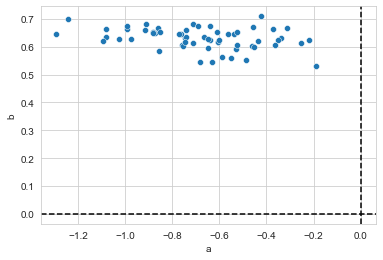

In [9]:
g = sns.scatterplot(data=aux, x='a', y='b')
g.axvline(0, ls='--', color='black')
g.axhline(0, ls='--', color='black');

The horizontal axis is probability of contraceptive use in rural area of a district. The vertical is the probability in urban area of same district. There urban areas above and below 0.5. All rural areas are below 0.5. However, for the same ditrict, the urban area is above the rural one. The negative correlation between the intercepts and slopes is necessary to encode this pattern.

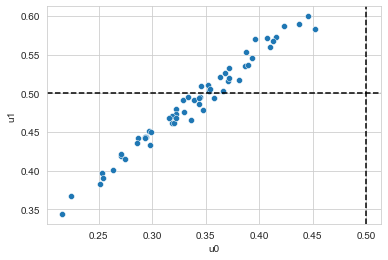

In [10]:
g = sns.scatterplot(data=aux, x='u0', y='u1')
g.axvline(0.5, ls='--', color='black')
g.axhline(0.5, ls='--', color='black');

In fact, if we fit the model so it instead has two intercepts, one for rural and one for urban, there is no strong correlation between those intercepts. Here's such a model:

In [11]:
def model(did, urban, contra=None):
    # fixed priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0, 1))
    b_bar = numpyro.sample('b_bar', dist.Normal(0, 0.5))
    sigma_ab = numpyro.sample('sigma_ab', dist.Exponential(1), sample_shape=(2,))
    rho = numpyro.sample('rho', dist.LKJ(2,2))
    # adaptive priors
    mu = jnp.stack([a_bar,b_bar])
    cov = jnp.outer(sigma_ab, sigma_ab)*rho
    i = len(d.did.unique())
    ab_did = numpyro.sample('ab_did', dist.MultivariateNormal(mu, cov), sample_shape=(i,))
    # likelihood
    theta = ab_did[did,urban]
    contra_hat = numpyro.sample('contra_hat', dist.Bernoulli(logits=theta), obs=contra)

In [12]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['did','urban','contra']].items()}
mcmc.run(rng_key, **dat)

sample: 100%|██████████| 1000/1000 [00:04<00:00, 239.82it/s, 15 steps of size 2.64e-01. acc. prob=0.85]


In [13]:
samples_12 = az.from_numpyro(mcmc)
az.summary(samples_12, var_names=['a_bar','b_bar', 'sigma_ab'], hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.72,0.10,-0.89,-0.56,0.00,0.00,1339.0,819.0,1.00
b_bar,0.02,0.12,-0.20,0.20,0.00,0.00,784.0,1178.0,1.00
sigma_ab[0],0.62,0.10,0.46,0.78,0.00,0.00,549.0,920.0,1.01
sigma_ab[1],0.48,0.15,0.25,0.72,0.01,0.01,101.0,92.0,1.02


Correlation all gone.

## Exercise 2

> Now consider the predictor variables age.centered and living.children, also contained in data(`bangladesh`). Suppose that age influences contraceptive use (changing attitudes) and number of children (older people have had more time to have kids). Number of children may also directly influence contraceptive use. Draw a DAG that reflects these hypothetical relationships. Then build models needed to evaluate the DAG. You will need at least two models. Retain district and urban, as in Problem 1. What do you conclude about the causal influence of age and children?

Here's my DAG:

<img src="./fig/w9_img1.png" width="20%">

`A` is age, `K` is number of children, and `C` is contraception use. To study this DAG, we should estimate both the total causal influence of `A` and then condition also on `K` and see if the direct influence of `A` is smaller. Here's the model for the total influence of A:

In [14]:
def model(did, urban, age, contra=None):
    # fixed priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0, 1))
    b_bar = numpyro.sample('b_bar', dist.Normal(0, 0.5))
    sigma_ab = numpyro.sample('sigma_ab', dist.Exponential(1), sample_shape=(2,))
    rho = numpyro.sample('rho', dist.LKJ(2,2))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    # adaptive priors
    mu = jnp.stack([a_bar,b_bar])
    cov = jnp.outer(sigma_ab, sigma_ab)*rho
    i, j = len(d.did.unique()), len(d.urban.unique())
    ab_did = numpyro.sample('ab_did', dist.MultivariateNormal(mu, cov), sample_shape=(i,j))
    # likelihood
    a_did, b_did = ab_did[:,:,0], ab_did[:,:,1]
    theta = a_did[did,urban] + b_did[did,urban]*urban + bA*age
    contra_hat = numpyro.sample('contra_hat', dist.Bernoulli(logits=theta), obs=contra)

In [15]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['did','urban','age','contra']].items()}
mcmc.run(rng_key, **dat)

sample: 100%|██████████| 1000/1000 [00:20<00:00, 49.44it/s, 63 steps of size 6.72e-02. acc. prob=0.95]


In [16]:
samples_21 = az.from_numpyro(mcmc)
az.summary(samples_21, var_names=['a_bar','b_bar', 'sigma_ab'], hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.67,0.10,-0.84,-0.52,0.01,0.01,76.0,311.0,1.05
b_bar,0.61,0.16,0.35,0.85,0.04,0.03,21.0,98.0,1.14
sigma_ab[0],0.59,0.09,0.46,0.75,0.01,0.00,252.0,438.0,1.01
sigma_ab[1],0.32,0.24,0.03,0.64,0.08,0.06,7.0,19.0,1.62


In this model, the total causal effect of `age` is positive and very small. Older individuals use slightly more contraception. And now the model with both `K` and `A`:

In [17]:
def model(did, urban, age, children, contra=None):
    # fixed priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0, 1))
    b_bar = numpyro.sample('b_bar', dist.Normal(0, 0.5))
    sigma_ab = numpyro.sample('sigma_ab', dist.Exponential(1), sample_shape=(2,))
    rho = numpyro.sample('rho', dist.LKJ(2,2))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    bK = numpyro.sample('bK', dist.Normal(0,0.5))
    # adaptive priors
    mu = jnp.stack([a_bar,b_bar])
    cov = jnp.outer(sigma_ab, sigma_ab)*rho
    i, j = len(d.did.unique()), len(d.urban.unique())
    ab_did = numpyro.sample('ab_did', dist.MultivariateNormal(mu, cov), sample_shape=(i,j))
    # likelihood
    a_did, b_did = ab_did[:,:,0], ab_did[:,:,1]
    theta = a_did[did,urban] + b_did[did,urban]*urban + bA*age + bK*children
    contra_hat = numpyro.sample('contra_hat', dist.Bernoulli(logits=theta), obs=contra)

In [18]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['did','urban','age', 'children', 'contra']].items()}
mcmc.run(rng_key, **dat)

sample: 100%|██████████| 1000/1000 [00:08<00:00, 113.71it/s, 31 steps of size 1.30e-01. acc. prob=0.81]


In [19]:
samples_22 = az.from_numpyro(mcmc)
az.summary(samples_22, var_names=['a_bar','b_bar', 'bA', 'bK'], hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.72,0.10,-0.88,-0.56,0.00,0.00,423.0,795.0,1.01
b_bar,0.70,0.17,0.46,0.99,0.01,0.01,177.0,415.0,1.01
bA,-0.26,0.07,-0.36,-0.14,0.00,0.00,412.0,1208.0,1.01
bK,0.51,0.07,0.40,0.62,0.00,0.00,1547.0,1391.0,1.01


In this model, the direct effect of `age` is negative, and much farther from zero than before. The effect of number of children is strong and positive. These results are consistent with the DAG, because they imply that the reason the total effect of age, from `model_21`, is positive is that older individuals also have more kids. Having more kids increases contraception. Being older, controlling for kids, actually makes contraception less likely.

## Exercise 3

> Modify any models from Problem 2 that contained that `children` variable and model the variable now as a monotonic ordered category, like education from the week we did ordered categories. Education in that example had 8 categories. Children here will have fewer (no one in the sample had 8 children). So modify the code appropriately. What do you conclude about the causal influence of each additional child on use of contraception?

To build this model, you need the ordered categorical predictor machinery from the book example. The maximum observed number of kids in the sample is 4. So that means we need three parameters, for three transitions in number of kids. Remember for monotonic ordered variables we have to start the categories at zero. 

In [20]:
def model(did, urban, age, children, contra=None):
    # fixed priors
    a_bar = numpyro.sample('a_bar', dist.Normal(0, 1))
    b_bar = numpyro.sample('b_bar', dist.Normal(0, 0.5))
    sigma_ab = numpyro.sample('sigma_ab', dist.Exponential(1), sample_shape=(2,))
    rho = numpyro.sample('rho', dist.LKJ(2,2))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    bK = numpyro.sample('bK', dist.Normal(0,0.5))
    children_coefs = numpyro.sample('children_coefs', dist.Dirichlet(np.ones(3)))
    # adaptive priors
    mu = jnp.stack([a_bar,b_bar])
    cov = jnp.outer(sigma_ab, sigma_ab)*rho
    i, j = len(d.did.unique()), len(d.urban.unique())
    ab_did = numpyro.sample('ab_did', dist.MultivariateNormal(mu, cov).expand([i,j]))
    # likelihood
    delta_j = jnp.pad(children_coefs, (1, 0))
    delta_K = jnp.sum(jnp.where(jnp.arange(4) <= children[..., None], delta_j, 0), -1)
    a_did, b_did = ab_did[:,:,0], ab_did[:,:,1]
    theta = a_did[did,urban] + b_did[did,urban]*urban + bA*age + bK*delta_K
    contra_hat = numpyro.sample('contra_hat', dist.Bernoulli(logits=theta), obs=contra)

In [21]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['did','urban','age', 'children', 'contra']].items()}
mcmc.run(rng_key, **dat)

sample: 100%|██████████| 1000/1000 [00:09<00:00, 107.73it/s, 31 steps of size 1.27e-01. acc. prob=0.79]


In [22]:
samples_31 = az.from_numpyro(mcmc)
az.summary(samples_31, var_names=['a_bar','b_bar', 'bA', 'bK', 'children_coefs'], hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.76,0.11,-0.95,-0.59,0.01,0.00,343.0,626.0,1.03
b_bar,0.65,0.17,0.38,0.91,0.01,0.01,190.0,341.0,1.07
bA,0.03,0.06,-0.07,0.12,0.00,0.00,1046.0,1352.0,1.03
bK,0.48,0.30,0.04,0.97,0.01,0.01,968.0,991.0,1.06
children_coefs[0],0.44,0.21,0.10,0.80,0.02,0.01,244.0,694.0,1.02
children_coefs[1],0.28,0.19,0.00,0.54,0.00,0.00,1474.0,1101.0,1.06
children_coefs[2],0.27,0.20,0.00,0.57,0.02,0.01,190.0,1143.0,1.03


So the general effects are the same: `age` reduces use and kids increase it (_parameter `bA`_). `children_coefs[0]` is the transition from 1 to 2 kids. It is much larger than the other two parameters. So most of the influence of kids on contraception comes from having a second child.